In [1]:
from glio.imports import *
import torch

In [2]:
def make_cubic(a,b,c,d):
    def cubic(x):
        return a * x**3 + b * x**2 + c * x + d
    return cubic

def make_cubic_derivative(a, b, c, d):
    def cubic_derivative(x):
        return 3 * a * x**2 + 2 * b * x + c
    return cubic_derivative

@torch.no_grad
def _fit_cubic_torch(x1:float,y1:float,y1_prime:float,x2:float,y2:float, y2_prime:float):
    """Fits a cubic polynomial to given points and derivative.

    Args:
      x1: x-coordinate of the first point.
      y1: y-coordinate of the first point.
      y1_prime: Derivative of the function at x1.
      x2: x-coordinate of the second point.
      y2: y-coordinate of the second point.

    Returns:
      A tuple (a, b, c) representing the coefficients of the quadratic polynomial.
    """

    A = torch.tensor([[x1**3, x1**2, x1, 1], [x2**3, x2**2, x2, 1], [3 * x1 ** 2, 2 * x1, 1, 0], [3 * x2 ** 2, 2 * x2, 1, 0]])
    b = torch.tensor([y1, y2, y1_prime, y2_prime])

    # Solve the system of linear equations
    coeffs = torch.linalg.solve(A, b)  # type:ignore #pylint:disable=E1102
    return coeffs

In [3]:
def find_cubic_minimum(a,b,c,d):
    # df = 3ax^2 + 2bx + c
    quad_a = 3 * a
    quad_b = 2 * b
    quad_c = c
    x1 = (-quad_b + (quad_b ** 2 - 4 * quad_a * quad_c)**0.5) / (2 * quad_a)
    x2 = (-quad_b - (quad_b ** 2 - 4 * quad_a * quad_c)**0.5) / (2 * quad_a)
    y1 = a * x1 ** 3 + b * x1 ** 2 + c * x1
    y2 = a * x2 ** 3 + b * x2 ** 2 + c * x2
    if y1 < y2: return x1
    return x2

def find_cubic_minimum2(a,b,c,d):
    x1 = (-b + (b**2 - 3 * a * c)**0.5) / (3 * a)
    x2 = (-b - (b**2 - 3 * a * c)**0.5) / (3 * a)
    y1 = a * x1 ** 3 + b * x1 ** 2 + c * x1
    y2 = a * x2 ** 3 + b * x2 ** 2 + c * x2
    if y1 < y2: return x1
    return x2

coeffs = tensor([  -6.8000,   51.3997, -124.2992,   97.8994])
minimum = tensor(2.0143)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


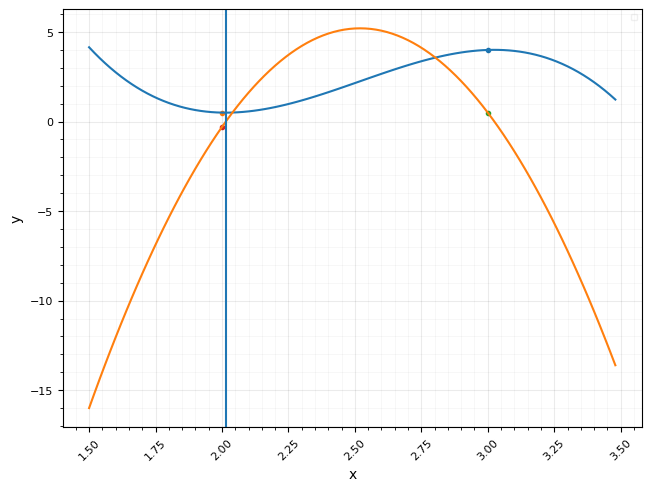

In [4]:
x1, y1, y1_prime = 3., 4., 0.5
x2, y2, y2_prime = 2., 0.5, -0.3

coeffs = _fit_cubic_torch(x1, y1, y1_prime, x2, y2, y2_prime)
print(f'{coeffs = }')

minimum = find_cubic_minimum2(*coeffs)
print(f'{minimum = }')

f = make_cubic(*coeffs)
df = make_cubic_derivative(*coeffs)

fig = Figure()
(
fig.add()
.funcplot1d(f, 1.5, 3.5, 100)
.funcplot1d(df, 1.5, 3.5, 100)
.point(x1, y1)
.point(x2, y2)
.point(x1, y1_prime)
.point(x2, y2_prime)
.vline(minimum)
.style_chart()
)
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


coeffs = tensor([-23.9999,  11.6400, -24.0000,  32.0000])
minimum = tensor(nan)


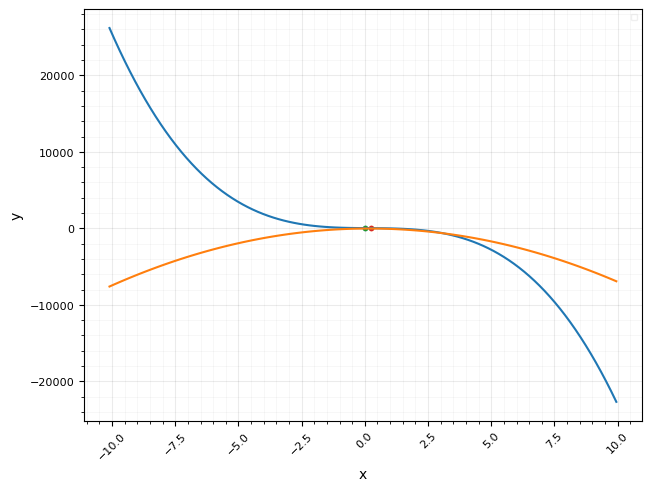

In [15]:
x1 = 0; y1 = 32.0; y1_prime = 24.0; x2 = 0.24; y2 = 26.57868766784668; y2_prime = 22.559999465942383
coeffs = _fit_cubic_torch(x1, y1, -y1_prime, x2, y2, -y2_prime)
print(f'{coeffs = }')

minimum = find_cubic_minimum2(*coeffs)
print(f'{minimum = }')

f = make_cubic(*coeffs)
df = make_cubic_derivative(*coeffs)

fig = Figure()
(
fig.add()
.funcplot1d(f, -10.1, 10.15, 100)
.funcplot1d(df, -10.1, 10.15, 100)
.point(x1, y1)
.point(x2, y2)
.point(x1, y1_prime)
.point(x2, y2_prime)
.vline(minimum)
.style_chart()
)
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


coeffs = tensor([1., 0., 0., -0.])
minimum = tensor(-0.)


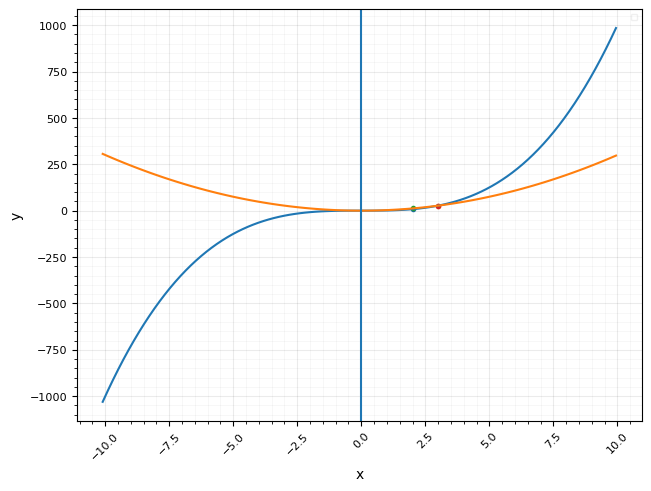

In [21]:
x1 = 2.; y1 = 8.; y1_prime = 12.; x2 = 3.; y2 = 27.; y2_prime = 27.
coeffs = _fit_cubic_torch(x1, y1, y1_prime, x2, y2, y2_prime)
print(f'{coeffs = }')

minimum = find_cubic_minimum2(*coeffs)
print(f'{minimum = }')

f = make_cubic(*coeffs)
df = make_cubic_derivative(*coeffs)

fig = Figure()
(
fig.add()
.funcplot1d(f, -10.1, 10.15, 100)
.funcplot1d(df, -10.1, 10.15, 100)
.point(x1, y1)
.point(x2, y2)
.point(x1, y1_prime)
.point(x2, y2_prime)
.vline(minimum)
.style_chart()
)
fig.show()